In [32]:
import json
import copy
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score ,f1_score, precision_score

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from pytorchtools import EarlyStopping

In [34]:
torch.__version__

'1.4.0'

## 1. PreProcessing

In [35]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('data.csv')
data = shuffle(data, random_state = 1)
data['year'] = pd.DatetimeIndex(data['date']).year
data = data[data['year'] > 1999].reset_index(drop=True)
#pd.set_option('display.max_rows', None) 

In [36]:
data["R_Stance"].replace({np.nan: "Switch", 'Open Stance' : 'Switch', 'Sideways' : 'Switch'}, inplace=True)
data["B_Stance"].replace({np.nan: "Switch", 'Open Stance' : 'Switch', 'Sideways' : 'Switch'}, inplace=True)

In [37]:
grouped_BR = data['R_Reach_cms'].groupby(data['weight_class'])
grouped_RR = data['B_Reach_cms'].groupby(data['weight_class'])
grouped_BH = data['R_Height_cms'].groupby(data['weight_class'])
grouped_RH = data['B_Height_cms'].groupby(data['weight_class'])
mean_age = np.mean(data['B_age'] + data['R_age'])/2
reach_means = (grouped_BR.mean() + grouped_RR.mean()) / 2
height_means = (grouped_BH.mean() + grouped_RH.mean()) / 2

In [38]:
for i in range(len(data)):
    row = data.iloc[i, :]
    if np.isnan(row['R_Reach_cms']):
        data.at[i, 'R_Reach_cms'] = reach_means[row['weight_class']]
    if np.isnan(row['B_Reach_cms']):
        data.at[i, 'B_Reach_cms'] = reach_means[row['weight_class']]
    if np.isnan(row['R_Height_cms']):
        data.at[i, 'R_Height_cms'] = height_means[row['weight_class']]
    if np.isnan(row['B_Height_cms']):
         data.at[i, 'B_Height_cms'] = height_means[row['weight_class']]
    if np.isnan(row['B_age']):
         data.at[i, 'B_age'] = mean_age
    if np.isnan(row['R_age']):
         data.at[i, 'R_age'] = mean_age

In [39]:
cols_useless = 'date year weight_class R_Weight_lbs B_Weight_lbs B_total_time_fought(seconds) R_total_time_fought(seconds) Referee	date	location R_avg_opp_BODY_att	R_avg_opp_BODY_landed	R_avg_opp_CLINCH_att	R_avg_opp_CLINCH_landed	R_avg_opp_DISTANCE_att	R_avg_opp_DISTANCE_landed	R_avg_opp_GROUND_att	R_avg_opp_GROUND_landed	R_avg_opp_HEAD_att	R_avg_opp_HEAD_landed	R_avg_opp_KD	R_avg_opp_LEG_att	R_avg_opp_LEG_landed	R_avg_opp_PASS	R_avg_opp_REV	R_avg_opp_SIG_STR_att	R_avg_opp_SIG_STR_landed	R_avg_opp_SIG_STR_pct	R_avg_opp_SUB_ATT	R_avg_opp_TD_att	R_avg_opp_TD_landed	R_avg_opp_TD_pct	R_avg_opp_TOTAL_STR_att	R_avg_opp_TOTAL_STR_landed B_avg_opp_BODY_att	B_avg_opp_BODY_landed	B_avg_opp_CLINCH_att	B_avg_opp_CLINCH_landed	B_avg_opp_DISTANCE_att	B_avg_opp_DISTANCE_landed	B_avg_opp_GROUND_att	B_avg_opp_GROUND_landed	B_avg_opp_HEAD_att	B_avg_opp_HEAD_landed	B_avg_opp_KD	B_avg_opp_LEG_att	B_avg_opp_LEG_landed	B_avg_opp_PASS	B_avg_opp_REV	B_avg_opp_SIG_STR_att	B_avg_opp_SIG_STR_landed	B_avg_opp_SIG_STR_pct	B_avg_opp_SUB_ATT	B_avg_opp_TD_att	B_avg_opp_TD_landed	B_avg_opp_TD_pct	B_avg_opp_TOTAL_STR_att	B_avg_opp_TOTAL_STR_landed'.split()
data = data.drop(cols_useless, axis=1).reset_index(drop=True)
featureToDrop = 'B_avg_SIG_STR_att	B_avg_SIG_STR_landed R_avg_SIG_STR_att	R_avg_SIG_STR_landed B_avg_LEG_att R_avg_LEG_att B_avg_TD_att R_avg_TD_att B_avg_LEG_landed R_avg_LEG_landed B_avg_PASS R_avg_PASS R_avg_BODY_att	R_avg_BODY_landed	R_avg_CLINCH_att	R_avg_CLINCH_landed	R_avg_DISTANCE_att	R_avg_DISTANCE_landed	R_avg_HEAD_att	R_avg_HEAD_landed                                  B_avg_BODY_att	B_avg_BODY_landed	B_avg_CLINCH_att	B_avg_CLINCH_landed	B_avg_DISTANCE_att	B_avg_DISTANCE_landed	B_avg_HEAD_att	B_avg_HEAD_landed   R_current_lose_streak	B_current_lose_streak	B_draw B_avg_GROUND_att	B_avg_GROUND_landed B_avg_REV B_avg_TD_pct B_total_title_bouts B_win_by_TKO_Doctor_Stoppage R_draw R_avg_GROUND_att	R_avg_GROUND_landed R_avg_REV R_avg_TD_pct R_total_title_bouts R_win_by_TKO_Doctor_Stoppage'.split()
data = data.drop(featureToDrop, axis=1).reset_index(drop=True)
data = data.replace(np.nan, 0)
print(data.shape)

(4936, 45)


### 1 - 1. Merge Features
B_win_by_Decision_Majority	B_win_by_Decision_Split	B_win_by_Decision_Unanimous -> B_win_by_Decision

In [40]:
data['B_win_by_Decision'] = np.sum(np.array(data[['B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous']]), axis=1)
data['R_win_by_Decision'] = np.sum(np.array(data[['R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous']]), axis=1)
data = data.drop(['B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous', 'R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous'], axis=1)
data = data[(data['no_of_rounds']!=2) & (data['no_of_rounds']!=4)]

### 1 - 2. Categorical Values
Categorival values to One-hot vector for embedding

In [41]:
categorical_vars = ['title_bout', 'B_Stance', 'R_Stance', 'no_of_rounds']
#title_bout = pd.get_dummies(data['title_bout'])
B_stance = pd.get_dummies(data['B_Stance'])
R_stance = pd.get_dummies(data['R_Stance'])
no_of_rounds = pd.get_dummies(data['no_of_rounds'])
winner = data['Winner'] == 'Red'
label = winner + 0
data = data.drop(categorical_vars, axis=1).reset_index(drop=True)

In [42]:
data.head()

,R_fighter,B_fighter,Winner,B_current_win_streak,B_avg_KD,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_total_rounds_fought,B_win_by_KO/TKO,B_win_by_Submission,B_wins,B_Height_cms,B_Reach_cms,R_current_win_streak,R_avg_KD,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_total_rounds_fought,R_win_by_KO/TKO,R_win_by_Submission,R_wins,R_Height_cms,R_Reach_cms,B_age,R_age,B_win_by_Decision,R_win_by_Decision
0,Drew McFedries,Marvin Eastman,Red,1.0,0.000000,0.282500,0.000000,0.25,59.000000,27.250000,1.0,3.0,8.0,0.0,0.0,1.0,175.26,185.420000,0.0,0.750000,0.532500,0.000000,0.250000,30.500000,16.750000,1.0,2.0,4.0,2.0,0.0,2.0,182.88,182.88,37.0,29.0,1.0,0.0
1,Melvin Guillard,Jeremy Stephens,Red,2.0,0.555556,0.463333,0.333333,1.00,81.555556,49.666667,2.0,4.0,22.0,2.0,0.0,5.0,172.72,180.340000,2.0,0.636364,0.381818,0.090909,1.181818,38.090909,15.818182,2.0,4.0,18.0,4.0,0.0,7.0,175.26,172.72,24.0,27.0,2.0,2.0
2,Yoshiyuki Yoshida,Jon Koppenhaver,Red,1.0,0.000000,0.600000,0.000000,1.00,156.000000,127.000000,1.0,0.0,3.0,1.0,0.0,1.0,180.34,185.904925,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,180.34,177.80,26.0,34.0,0.0,0.0
3,Justin Scoggins,Said Nurmagomedov,Blue,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,172.72,177.800000,0.0,0.125000,0.582500,0.375000,2.875000,94.250000,56.750000,2.0,4.0,19.0,1.0,0.0,4.0,170.18,167.64,26.0,26.0,0.0,3.0
4,Jim Alers,Jason Knight,Blue,0.0,0.000000,0.660000,1.000000,0.00,61.000000,44.000000,0.0,1.0,3.0,0.0,0.0,0.0,177.80,180.340000,0.0,0.333333,0.403333,0.333333,1.000000,106.000000,54.333333,1.0,2.0,7.0,0.0,0.0,1.0,175.26,180.34,24.0,29.0,0.0,1.0


### 1 -3. New features : WinPoint, LosePoint

In [43]:
grouped_Bwin = data['B_wins'].groupby(data['B_fighter'])
grouped_Rwin = data['R_wins'].groupby(data['R_fighter'])

In [44]:
fighters = list(set(list(data['R_fighter']) + list(data['B_fighter'])))
cum_wins = {}
cum_losses = {}
how_strong = {}
how_weak = {}
for f in fighters:
    cum_wins[f] = 0
    cum_losses[f] = 0
    how_strong[f] = 0
    how_weak[f] = 0

In [45]:
for i in range(len(data)):
    if data['Winner'][i] == 'Red':
        cum_wins[data['R_fighter'][i]] += 1
        cum_losses[data['B_fighter'][i]] += 1
    elif data['Winner'][i] == 'Blue':
        cum_losses[data['R_fighter'][i]] += 1
        cum_wins[data['B_fighter'][i]] += 1

In [46]:
for i in range(len(data)):
    if data['Winner'][i] == 'Red':
        how_strong[data['R_fighter'][i]] += cum_wins[data['B_fighter'][i]]
        how_weak[data['B_fighter'][i]] += cum_losses[data['R_fighter'][i]]
    elif data['Winner'][i] == 'Blue':
        how_strong[data['B_fighter'][i]] += cum_wins[data['R_fighter'][i]]
        how_weak[data['R_fighter'][i]] += cum_losses[data['B_fighter'][i]]

In [47]:
R_WinPoint = []
B_WinPoint = []
R_LosePoint = []
B_LosePoint = []
for i in range(len(data)):
    R_WinPoint.append(how_strong[data['R_fighter'][i]])
    B_WinPoint.append(how_strong[data['B_fighter'][i]])
    R_LosePoint.append(how_weak[data['R_fighter'][i]])
    B_LosePoint.append(how_weak[data['B_fighter'][i]])
data['R_WinPoint'] = R_WinPoint
data['R_LosePoint'] = R_LosePoint
data['B_WinPoint'] = B_WinPoint
data['B_LosePoint'] = B_LosePoint

In [48]:
data.shape

(4905, 41)

### 1 - 4. Split Numerical / Caterorical Values

In [49]:
data_numeric = data.drop(['R_fighter', 'B_fighter', 'Winner'], axis=1)

In [50]:
data_numeric.head()

,B_current_win_streak,B_avg_KD,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_total_rounds_fought,B_win_by_KO/TKO,B_win_by_Submission,B_wins,B_Height_cms,B_Reach_cms,R_current_win_streak,R_avg_KD,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_total_rounds_fought,R_win_by_KO/TKO,R_win_by_Submission,R_wins,R_Height_cms,R_Reach_cms,B_age,R_age,B_win_by_Decision,R_win_by_Decision,R_WinPoint,R_LosePoint,B_WinPoint,B_LosePoint
0,1.0,0.000000,0.282500,0.000000,0.25,59.000000,27.250000,1.0,3.0,8.0,0.0,0.0,1.0,175.26,185.420000,0.0,0.750000,0.532500,0.000000,0.250000,30.500000,16.750000,1.0,2.0,4.0,2.0,0.0,2.0,182.88,182.88,37.0,29.0,1.0,0.0,7,33,2,23
1,2.0,0.555556,0.463333,0.333333,1.00,81.555556,49.666667,2.0,4.0,22.0,2.0,0.0,5.0,172.72,180.340000,2.0,0.636364,0.381818,0.090909,1.181818,38.090909,15.818182,2.0,4.0,18.0,4.0,0.0,7.0,175.26,172.72,24.0,27.0,2.0,2.0,73,80,92,102
2,1.0,0.000000,0.600000,0.000000,1.00,156.000000,127.000000,1.0,0.0,3.0,1.0,0.0,1.0,180.34,185.904925,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,180.34,177.80,26.0,34.0,0.0,0.0,1,19,0,3
3,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,172.72,177.800000,0.0,0.125000,0.582500,0.375000,2.875000,94.250000,56.750000,2.0,4.0,19.0,1.0,0.0,4.0,170.18,167.64,26.0,26.0,0.0,3.0,7,21,7,0
4,0.0,0.000000,0.660000,1.000000,0.00,61.000000,44.000000,0.0,1.0,3.0,0.0,0.0,0.0,177.80,180.340000,0.0,0.333333,0.403333,0.333333,1.000000,106.000000,54.333333,1.0,2.0,7.0,0.0,0.0,1.0,175.26,180.34,24.0,29.0,0.0,1.0,0,9,23,15


In [51]:
data_numeric = StandardScaler().fit_transform(data_numeric)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [52]:
data_numeric.shape

(4905, 38)

## 2. Dataset

### 2- 1. Split Train, Test with 9 : 1

In [53]:
numeric_train, numeric_test = train_test_split(data_numeric, test_size = 0.1, random_state=2)
#title_train, title_test = train_test_split(title_bout, test_size = 0.1, random_state=2)
R_stance_train, R_stance_test,  = train_test_split(R_stance, test_size = 0.1, random_state=2)
B_stance_train, B_stance_test = train_test_split(B_stance, test_size = 0.1, random_state=2)
no_of_rounds_train, no_of_rounds_test = train_test_split(no_of_rounds, test_size = 0.1, random_state =2)
label_train, label_test = train_test_split(label, test_size = 0.1, random_state = 2)

In [54]:
numeric_test = torch.FloatTensor(np.array(numeric_test)).to('cuda')
#title_test = torch.FloatTensor(np.array(title_test)).to('cuda')
R_stance_test = torch.FloatTensor(np.array(R_stance_test)).to('cuda')
B_stance_test = torch.FloatTensor(np.array(B_stance_test)).to('cuda')
no_of_rounds_test = torch.FloatTensor(np.array(no_of_rounds_test)).to('cuda')
#label_test = torch.LongTensor(np.array(label_test)).to('cuda')

### 2- 2. Split Train, Val
#### BatchSize = 8

In [55]:
numeric_training, numeric_val = train_test_split(numeric_train, test_size = 0.05, random_state=2)
#title_training, title_val = train_test_split(title_train, test_size = 0.05, random_state=2)
R_stance_training, R_stance_val  = train_test_split(R_stance_train, test_size = 0.05, random_state=2)
B_stance_training, B_stance_val = train_test_split(B_stance_train, test_size = 0.05, random_state=2)
no_of_rounds_training, no_of_rounds_val = train_test_split(no_of_rounds_train, test_size = 0.05, random_state =2)
label_training, label_val = train_test_split(label_train, test_size = 0.05, random_state = 2)

In [56]:
numeric_training = torch.FloatTensor(np.array(numeric_training))
#title_training = torch.FloatTensor(np.array(title_training))
R_stance_training = torch.FloatTensor(np.array(R_stance_training))
B_stance_training = torch.FloatTensor(np.array(B_stance_training))
no_of_rounds_training = torch.FloatTensor(np.array(no_of_rounds_training))
label_training = torch.LongTensor(np.array(label_training))
numeric_loader = torch.utils.data.DataLoader(numeric_training, batch_size=8)
#title_loader = torch.utils.data.DataLoader(title_training, batch_size=8)
R_stance_loader = torch.utils.data.DataLoader(R_stance_training, batch_size=8)
B_stance_loader = torch.utils.data.DataLoader(B_stance_training, batch_size=8)
no_of_rounds_loader = torch.utils.data.DataLoader(no_of_rounds_training, batch_size=8)
label_loader = torch.utils.data.DataLoader(label_training, batch_size=8)

numeric_val = torch.FloatTensor(np.array(numeric_val))
#title_val = torch.FloatTensor(np.array(title_val))
R_stance_val = torch.FloatTensor(np.array(R_stance_val))
B_stance_val = torch.FloatTensor(np.array(B_stance_val))
no_of_rounds_val = torch.FloatTensor(np.array(no_of_rounds_val))
label_val = torch.LongTensor(np.array(label_val))
numeric_vloader = torch.utils.data.DataLoader(numeric_val, batch_size=8)
#title_vloader = torch.utils.data.DataLoader(title_val, batch_size=8)
R_stance_vloader = torch.utils.data.DataLoader(R_stance_val, batch_size=8)
B_stance_vloader = torch.utils.data.DataLoader(B_stance_val, batch_size=8)
no_of_rounds_vloader = torch.utils.data.DataLoader(no_of_rounds_val, batch_size=8)
label_vloader = torch.utils.data.DataLoader(label_val, batch_size=8)

print('batch size : 8, num of batch_train : {}, num of batch_validation : {}'.format(len(label_loader), len(label_vloader)))

batch size : 8, num of batch_train : 525, num of batch_validation : 28


## 3. ANN Classifier for UFC

In [57]:
#categorical value 는 onehot 형태로 concateneate 되어서 input
class UFCmodel(nn.Module):
    def __init__(self):
        super(UFCmodel, self).__init__()
        self.R_stance_layer = nn.Linear(3, 1, bias=False)
        self.B_stance_layer = nn.Linear(3, 1, bias=False)
        self.no_of_rounds_layer = nn.Linear(2, 1, bias=False)
        #self.title_bout_layer = nn.Linear(2, 2, bias=False)
        self.fc1 = nn.Linear(41, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 2)
        self.dropout = nn.Dropout(p=0.05)
        self.batchnorm1 = nn.BatchNorm1d(60)
        self.batchnorm2 = nn.BatchNorm1d(30)
    def forward(self, numeric, r_stance, b_stance, no_of_rounds):
        '''
        input
        x : numeric variables (batch size x dim)
        e : categorical one_hot vectors
        concateneate (x+e) and input to FC Layer
        '''
        r_stance = self.R_stance_layer(r_stance)
        b_stance = self.B_stance_layer(b_stance)
        no_of_rounds = self.no_of_rounds_layer(no_of_rounds)
        #title_bout = self.title_bout_layer(title_bout)
        
        x = torch.cat((numeric, r_stance, b_stance, no_of_rounds), 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)

        return self.fc3(x)
    
    def predict(self, numeric, r_stance, b_stance, no_of_rounds):
        #Apply softmax to output. 
        res = self.forward(numeric, r_stance, b_stance, no_of_rounds)
        pred = F.softmax(res, dim=1)
        
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

## 4. Training, valiation

In [58]:
epochs = 10
model = UFCmodel()
model.cuda()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
total_steps = len(label_loader) * epochs
#create the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
                                            #num_warmup_steps = 0,
                                            #num_training_steps = total_steps

In [59]:
model

UFCmodel(
  (R_stance_layer): Linear(in_features=3, out_features=1, bias=False)
  (B_stance_layer): Linear(in_features=3, out_features=1, bias=False)
  (no_of_rounds_layer): Linear(in_features=2, out_features=1, bias=False)
  (fc1): Linear(in_features=41, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=2, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
  (batchnorm1): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [60]:
seed_val = 24
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
early_stopping = EarlyStopping(patience=2, verbose = True)
loss_train = []
loss_val = []
for epoch in range(0, epochs):
    
    #train
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
    train_loss = 0
    val_loss = 0
    model.train()
    step = 0
    for numeric, rs, bs, nor,label in zip(numeric_loader, R_stance_loader, B_stance_loader, no_of_rounds_loader, label_loader):
        
        if len(numeric) == 1:
            continue
        step += 1
        numeric = numeric.to('cuda')
        rs = rs.to('cuda')
        bs = bs.to('cuda')
        nor = nor.to('cuda')
        #title = title.to('cuda')
        label = label.to('cuda')
        y_pred = model.forward(numeric, rs, bs, nor)
        
        optimizer.zero_grad()
        clf_loss = criterion(y_pred, label)
        #if step % 100 == 0 and not step == 0:
         #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(label_loader)))
            
        
        train_loss += clf_loss.item()
        clf_loss.backward()
        optimizer.step()
        
    
    avg_train_loss = train_loss / len(label_loader)
    loss_train.append(avg_train_loss)
                             
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))

    # validation
    print("")
    print('Running Validaiton...')
    model.eval()
    for numeric_v, rs_v, bs_v, nor_v, label_v in zip(numeric_vloader, R_stance_vloader, B_stance_vloader, no_of_rounds_vloader, label_vloader):
        numeric_v = numeric_v.to('cuda')
        rs_v = rs_v.to('cuda')
        bs_v = bs_v.to('cuda')
        nor_v = nor_v.to('cuda')
        #title_v = title_v.to('cuda')
        label_v = label_v.to('cuda')
        
        with torch.no_grad():
            y_pred_val = model.forward(numeric_v, rs_v, bs_v, nor_v)
            clf_loss_val = criterion(y_pred_val, label_v)
            val_loss += clf_loss_val.item()
        scheduler.step(clf_loss_val)
    
    avg_val_loss = val_loss / len(label_vloader)
    loss_val.append(avg_val_loss)
    
    print("Average validation loss: {0:.2f}".format(avg_val_loss))
    early_stopping(avg_val_loss, model)
    
    if early_stopping.early_stop: 
        print("Early stopping executed")
        break
        
    model.load_state_dict(torch.load('checkpoint.pt'))

print("Training UFC model is finished!")


======== Epoch 1 / 10 ========
Training...

Average training loss: 0.59

Running Validaiton...
Average validation loss: 0.55
Validation loss decreased ( inf --> 0.553450). Saving model ...

======== Epoch 2 / 10 ========
Training...

Average training loss: 0.54

Running Validaiton...
Average validation loss: 0.55
Validation loss decreased ( 0.553450 --> 0.552441). Saving model ...

======== Epoch 3 / 10 ========
Training...

Average training loss: 0.53

Running Validaiton...
Average validation loss: 0.55
Validation loss decreased ( 0.552441 --> 0.551726). Saving model ...

======== Epoch 4 / 10 ========
Training...

Average training loss: 0.53

Running Validaiton...
Average validation loss: 0.55
EarlyStopping counter: 1 out of 2

======== Epoch 5 / 10 ========
Training...

Average training loss: 0.53

Running Validaiton...
Average validation loss: 0.55
Validation loss decreased ( 0.551726 --> 0.548979). Saving model ...

======== Epoch 6 / 10 ========
Training...

Average training los

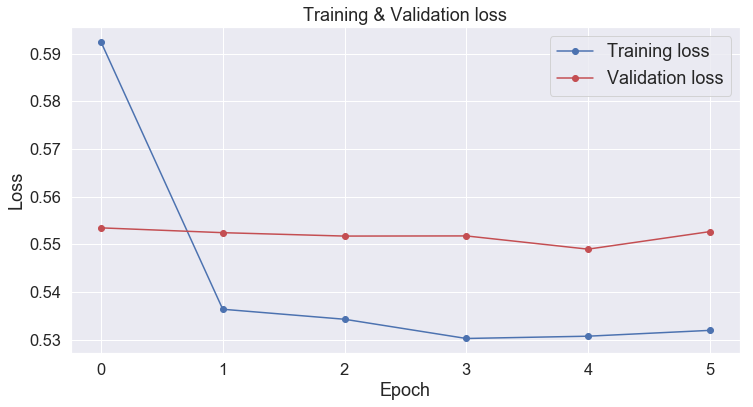

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_train, 'b-o', label='Training loss')
plt.plot(loss_val, 'r-o', label='Validation loss')
plt.legend(loc=1, fontsize='medium')
# Label the plot.
plt.title("Training & Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## 5. Prediction Accuracy Test for 500 fights

In [62]:
model.eval()
pred = model.predict(numeric_test,R_stance_test, B_stance_test, no_of_rounds_test)
pred = pred.numpy()
print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(accuracy_score(label_test, pred), precision_score(label_test, pred)))

Accuracy : 0.7495, Precision : 0.7539
